In [1]:
import numpy as np
import pandas as pd  
import xarray as xr 

In [9]:
fn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/19maps_MCDO_36yrtraining_RMMERA5_filtered_trop_season/output/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_mon12_lead1_dailyinput_mem1d.nc'
xr.open_dataset(fn)

<xarray.Dataset>
Dimensions:   (time: 607, mode: 2, N: 100)
Coordinates:
  * time      (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2020-03-31
  * mode      (mode) int64 0 1
  * N         (N) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    RMMp      (time, mode) float64 ...
    RMMt      (time, mode) float64 ...
    RMMp_dis  (time, N, mode) float64 ...
Attributes:
    description:  RMM prediction

In [2]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [14]:
# analyze error source
RMSE = []
amp_err  = []
pha_err = []
BCC = []


for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

    fn = './output/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_mon12_lead'+str(leadmjo)+'_dailyinput_mem1d.nc'

    dsfn_sel = xr.open_dataset(fn)

    # # calculate BCC for each MCDO
    # r1p = np.asarray(dsfn_sel['RMMp_dis'][:,:,0]).squeeze()
    # r2p = np.asarray(dsfn_sel['RMMp_dis'][:,:,1]).squeeze()

    # r1t = np.asarray(dsfn_sel['RMMt'][:,0]).reshape((-1, 1))
    # r2t = np.asarray(dsfn_sel['RMMt'][:,1]).reshape((-1, 1))

    # calculate BCC for each MCDO
    r1p = np.asarray(dsfn_sel['RMMp'][:,0]).reshape((-1, 1))
    r2p = np.asarray(dsfn_sel['RMMp'][:,1]).reshape((-1, 1))

    r1t = np.asarray(dsfn_sel['RMMt'][:,0]).reshape((-1, 1))
    r2t = np.asarray(dsfn_sel['RMMt'][:,1]).reshape((-1, 1))

    # print(np.shape(r1p))
    # print(np.shape(r2t))

    # BCC  [Nsamp]
    a = np.sum(r1p*r1t+r2p*r2t, axis=0)
    b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
    c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
    BCC.append(a/b/c) 

    # RMSE [time, Nsamp]
    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    RMSE.append(np.sqrt(d))  # RMSE at each time step

    # phase error [time, Nsamp]
    a = r1t * r2p - r2t * r1p 
    b = r1t * r1p + r2t * r2p
    c = a / b 
    d = np.arctan(c) * 180. / np.pi
    pha_err.append(d)

    # amplitude error [time, Nsamp] prediction - truth
    a = np.sqrt(r1p*r1p+r2p*r2p)
    b = np.sqrt(r1t*r1t+r2t*r2t)
    c = a - b 
    amp_err.append(c)

    del dsfn_sel




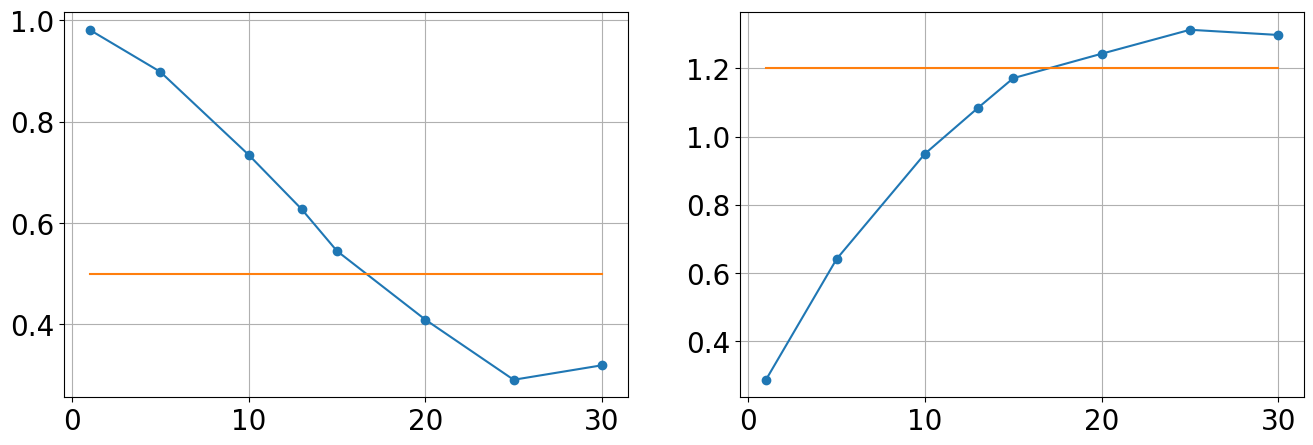

In [16]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1, 2, hspace=0.05, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

ax[0].plot(lead, BCC, 'o-')
ax[0].plot(lead, 0.5 * np.ones(len(lead)))
ax[0].grid(visible=True)

RMSEav = np.mean(np.asarray(RMSE), axis=1)

ax[1].plot(lead, RMSEav, 'o-')
ax[1].plot(lead, 1.2 * np.ones(len(lead)))
ax[1].grid(visible=True)



In [10]:
def get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta))
    tend = np.datetime64(str(testyrend)) - np.timedelta64(1, 'D')

    # RMM index in all seasons, amplitudes and phases.
    fnRMM = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
    dsrmm0 = xr.open_dataset(fnRMM)

    mask_season = dsrmm0.time.dt.month.isin(season_list)

    dsrmm0 = dsrmm0.where(mask_season, drop=True)

    dsrmm = dsrmm0.sel(time=slice(tsta, tend))
    RMMi1 = dsrmm['RMM'][:,0]
    RMMi2 = dsrmm['RMM'][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)
    print(time_len0)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        fn = './output/predicted_MCDO_UNET_19mapstrop_RMMERA5_36yr_mon12_lead'+str(leadmjo)+'_dailyinput_mem1d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])
        print(time_len1)

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn['RMMt'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))['RMM'].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)

        # calculate BCC for each MCDO
        r1p = np.asarray(dsfn_sel['RMMp_dis'][:,:,0]).squeeze()
        r2p = np.asarray(dsfn_sel['RMMp_dis'][:,:,1]).squeeze()

        r1t = np.asarray(dsfn_sel['RMMt'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel['RMMt'][:,1]).reshape((-1, 1))

        # # calculate BCC for each MCDO
        # r1p = np.asarray(dsfn_sel['RMMp'][:,0])
        # r2p = np.asarray(dsfn_sel['RMMp'][:,1])

        # r1t = np.asarray(dsfn_sel['RMMt'][:,0])
        # r2t = np.asarray(dsfn_sel['RMMt'][:,1])

        # print(np.shape(r1p))
        # print(np.shape(r2t))

        # BCC  [Nsamp]
        a = np.sum(r1p*r1t+r2p*r2t, axis=0)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCC.append(a/b/c) 

        # RMSE [time, Nsamp]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE.append(np.sqrt(d))  # RMSE at each time step

        # phase error [time, Nsamp]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_err.append(d)

        # amplitude error [time, Nsamp] prediction - truth
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = a - b 
        amp_err.append(c)

        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err

In [11]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
testyrsta = 2015
testyrend = 2020
nmem = 1

BCC, RMSE, pha_err, amp_err = get_BCC_RMSE(lead, testyrsta, testyrend, nmem, season_list=[12,1,2,3], Iniamp0=1, Inipha_list=np.arange(1,9))

606
516


AssertionError: Time lengths in RMM raw file and predcition are different